In [1]:
import numpy as np
import networkx as nx
from ipysigma import Sigma
import matplotlib.pyplot as plt
np.random.seed(0)


In [2]:
class WrightFisher:
    def __init__(self, n_pop):
        self.n_pop = n_pop
        self.graph = nx.DiGraph()
        self.gen = 0
        for i in range(n_pop):
            self.graph.add_node(i, y=i, x=0)

    def next_generation(self):
        self.gen += 1

        # select parents
        last_gen = range((self.gen - 1) * self.n_pop, self.gen * self.n_pop)
        parents = np.random.choice(last_gen, size=self.n_pop, replace=True)
        parents.sort()

        # update the graph
        base = self.gen * self.n_pop
        for i, parent in enumerate(parents):
            self.graph.add_node(base + i, y=i, x=self.gen)
            self.graph.add_edge(parent, base + i)


In [3]:
def total_branch_length(wf, t):
    ans = 0
    gen = range(t * wf.n_pop, (t + 1) * wf.n_pop)
    parent = lambda node: list(wf.graph.predecessors(node))[0]
    while t > 0 and len(gen) > 1:
        t -= 1
        ans += len(gen)
        # color edges to parents for nodes in gen
        for i in gen:
            for j in wf.graph.predecessors(i):
                wf.graph.add_edge(j, i, color='red')
        gen = set(parent(i) for i in gen)
    return ans

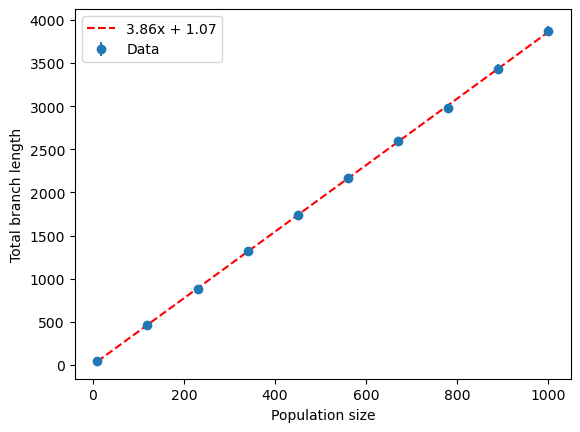

In [4]:
# Study how the total branch length in Y axis changes with the population size in X axis
n_pops = np.linspace(10, 1000, 10, dtype=int)
n_reps = 10
t_max = 10

means = np.zeros(len(n_pops))
stds = np.zeros(len(n_pops))

for i, n_pop in enumerate(n_pops):
    results = np.zeros(n_reps)
    for j in range(n_reps):
        wf = WrightFisher(n_pop)
        for t in range(t_max):
            wf.next_generation()
        results[j] = total_branch_length(wf, t_max)
    means[i] = np.mean(results)
    stds[i] = np.std(results)

# fit a line to the data

p = np.polyfit(n_pops, means, 1)
plt.plot(n_pops, np.polyval(p, n_pops), 'r--', label=f'{p[0]:.2f}x + {p[1]:.2f}')
plt.errorbar(n_pops, means, yerr=stds, fmt='o', label='Data')
plt.xlabel('Population size')
plt.ylabel('Total branch length')
plt.legend()
plt.show()

In [5]:
def simulate(n_pop):
    t_max = 1000

    wf = WrightFisher(n_pop)
    for t in range(t_max):
        wf.next_generation()
    
    total_branch_lengths = np.zeros(t_max + 1)
    for t in range(t_max + 1):
        total_branch_lengths[t] = total_branch_length(wf, t)
    return np.mean(total_branch_lengths), np.std(total_branch_lengths)

In [6]:
n_pops = np.linspace(10, 100, 10, dtype=int)
results = np.zeros((len(n_pops), 2))
for i, n_pop in enumerate(n_pops):
    results[i] = simulate(n_pop)
    print(f'Population size: {n_pop}, mean: {results[i, 0]}, std: {results[i, 1]}')

Population size: 10, mean: 56.06293706293706, std: 20.944411345235668
Population size: 20, mean: 161.42157842157843, std: 55.9645250657973
Population size: 30, mean: 235.28371628371627, std: 72.15388583668998
Population size: 40, mean: 288.25074925074927, std: 61.55276856989816
Population size: 50, mean: 444.2917082917083, std: 141.83206438140894
Population size: 60, mean: 544.0359640359641, std: 148.05576043199943
Population size: 70, mean: 633.977022977023, std: 185.40929282445043
Population size: 80, mean: 714.971028971029, std: 149.23686045786692
Population size: 90, mean: 809.6693306693306, std: 189.8242247768693
Population size: 100, mean: 1020.3116883116883, std: 270.946708108093


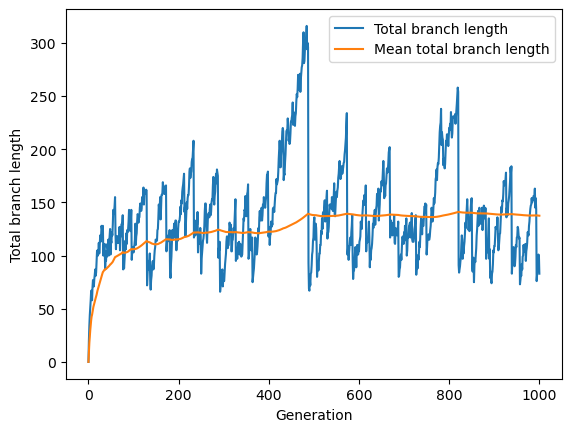

In [7]:
# plot total branch length for a single simulation in function of generation
n_pop = 20
t_max = 1000

wf = WrightFisher(n_pop)
for t in range(t_max):
    wf.next_generation()

total_branch_lengths = [total_branch_length(wf, t) for t in range(t_max + 1)]
cum_mean = np.cumsum(total_branch_lengths) / np.arange(1, t_max + 2)

plt.plot(total_branch_lengths, label='Total branch length')
plt.plot(cum_mean, label='Mean total branch length')
plt.xlabel('Generation')
plt.ylabel('Total branch length')
plt.legend()
plt.show()

In [8]:
wf = WrightFisher(6)
for i in range(10):
    wf.next_generation()

total_branch_length(wf, 4)

s = Sigma(wf.graph, hide_info_panel=True, hide_search=True)

s

Sigma(nx.DiGraph with 66 nodes and 60 edges)

Soit $p_{n, t}$ la probabilité qu'un individu fixé de la première génération soit connecté à la t-ième génération, dans un modèle de Wright Fisher avec $n$ individus par génération.

In [ ]:
# compute p(n,1) and compare with 1 - (1 - 1/n)^n

n_pops = np.linspace(10, 1000, 10, dtype=int)
n_reps = 10
t = 1

results = np.zeros(len(n_pops))
for i, n_pop in enumerate(n_pops):
    total = 0
    for j in range(n_reps):
        wf = WrightFisher(n_pop)
        wf.next_generation()
        total += wf.graph.out_degree(0) > 0
    results[i] = total / n_reps

plt.plot(n_pops, results, 'o', label='Data')
plt.plot(n_pops, 1 - (1 - 1 / n_pops) ** n_pops, 'r--', label='1 - (1 - 1/n)^n')
# limit 1 - 1/e
plt.axhline(1 - 1 / np.e, color='g', linestyle='--', label='1 - 1/e')
plt.xlabel('Population size')
plt.ylabel('p(n,1)')
plt.legend()